# Анализ Maise данных

## Загрузка данных

### Анализируемые данные
- `T1` - данные с сервера T1, где размер буффера 8 мб
- `T3` - данные с сервера Т3, где стандартный размер буффера

Потоки `trade` и `level` для инструментов `BTCUSDT` и `1000PEPEUSDT` за 18.01.2025

In [ ]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

# USE_COLS - используемые столбцы
# SECTION - секция на бирже
# SECURITIES - инструменты
# STREAMS - потоки данных
RECEIVE_TS = "receive_ts"
EXCHANGE_TS = "exchange_ts"
COLUMN = RECEIVE_TS
USE_COLS=[COLUMN]
SECTION = "BINANCE_USDM"
SECURITIES = ["BTCUSDT", "1000PEPEUSDT"]
SERVERS = ["T1", "T3"]
STREAMS = ["trade", "level"]
DATA_DIR = Path("data")


# Получение путей к данным из /data/{SERVER}/{SECTION}/{SECURITY}/{STREAM}.csv

# data_paths = {
#     security: {
#         stream: {
#             server: DATA_DIR / server / SECTION / security / f"{stream}.csv"
#             for server in SERVERS
#         }
#         for stream in STREAMS
#     }
#     for security in SECURITIES
# }

# Загрузка данных
data = pd.read_csv("data_t3.csv")

# Преобразуем receive_ts в числовой формат (если это ещё не сделано)
data[COLUMN] = pd.to_numeric(data[COLUMN])

# Сортируем данные по receive_ts
data = data.sort_values(by=COLUMN).reset_index(drop=True)

# Вычисляем разницу между соседними значениями
data['time_diff'] = data[COLUMN].diff()

# Удаляем первую строку, так как разница для неё NaN
data = data.dropna(subset=['time_diff'])

# Преобразуем receive_ts в секунды (для удобства)
data[COLUMN] = pd.to_datetime(data[COLUMN], unit="us")
# Построение timeline-графика
plt.figure(figsize=(12, 6))

# Ось X: receive_ts в секундах, Ось Y: задержка (time_diff)
plt.plot(data[COLUMN], data['time_diff'], linestyle='-', color='b', label='Задержка')

# Настройка графика
plt.title(f'Timeline: Задержка между значениями {COLUMN}')
plt.xlabel('Время (секунды)')
plt.ylabel('Задержка (микросекунды)')
plt.grid(True)
plt.legend()

# Отображение графика
plt.show()


/var/folders/tq/qclfykkn1z7_j0yl26mxbscr0000gn/T/ipykernel_82629/2177647635.py:60: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


На данном этапе мы загрузили данные с серверов T1 и T3, где размер буффера 8 мб и стандартный размер буффера соответственно. Данные представлены в виде потоков `trade` и `level` для инструментов `BTCUSDT` и `1000PEPEUSDT` за 18.01.2025.

Данные можно получить из переменной `data_paths`:
например, данные для инструмента `BTCUSDT` и потока `trade` с сервера T1:
```python
data_paths["BTCUSDT"]["trade"]["T1"]
```

In [16]:
print("\nАнализ разницы:")
print(f"Средняя разница: {data['time_diff'].mean()}")
print(f"Медиана разницы: {data['time_diff'].median()}")
print(f"Минимальная разница: {data['time_diff'].min()}")
print(f"Максимальная разница: {data['time_diff'].max()}")
print(f"Стандартное отклонение: {data['time_diff'].std()}")


Анализ разницы:
Средняя разница: 2896.6394972723324
Медиана разницы: 2000.0
Минимальная разница: 1000.0
Максимальная разница: 1654000.0
Стандартное отклонение: 2541.0088589730053


In [3]:
# Загрузим данные в Pandas DataFrame для дальнейшего анализа

# data = {
#     security: {
#         stream: {
#             server: pd.read_csv(path, usecols=USE_COLS, delimiter=";")
#             for server, path in paths.items()
#         }
#         for stream, paths in paths.items()
#     }
#     for security, paths in data_paths.items()
# }

trade_data = pd.read_csv(path, usecols=USE_COLS, delimiter=";")


In [8]:
# Пример загруженных данных для T3
# Отсортировать от более ранних данных к более поздним

trade_data.sort_values(by="receive_ts", ascending=False).head()

,receive_ts
4198098,1737244799999830
23008879,1737244799998861
13795842,1737244799995582
32098094,1737244799994604
19217876,1737244799990323


In [19]:
# Рассчитаем receive_ts_diff для данных на серверах

# Отобразим разницу между временем получения данных в миллисекундах
trade_data["receive_ts_diff"] = trade_data["receive_ts"].diff()

# Пример рассчитанного Jitter
trade_data["receive_ts_diff"].dropna().dropna()


<bound method Series.min of 1            15756.0
2            48538.0
3            55461.0
4           216866.0
5            71729.0
              ...   
35282005     52573.0
35282006     51649.0
35282007     52198.0
35282008    104694.0
35282009     52069.0
Name: receive_ts_diff, Length: 35282009, dtype: float64>

In [23]:
# Приведем данные к формату datetime

trade_data["receive_ts"] = pd.to_datetime(trade_data["receive_ts"], unit="us")


In [15]:
# Пример рассчитанного Jitter
trade_data["receive_ts_diff"].max()

np.float64(80327103.0)

<Axes: title={'center': 'Receive_ts diff for T3'}, xlabel='receive_ts'>

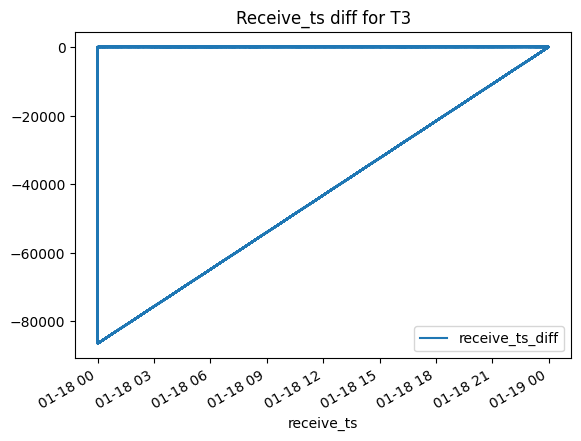

In [9]:
# Построим график receive_ts diff для данных
trade_data.plot(x="receive_ts", y="receive_ts_diff", title=f"Receive_ts diff for T3")


In [10]:
# Посчитаем количество значений, которые больше 0.1 и 0.5 и 1 и выведем в таблицу

print("Server: T1:")
print(f"Count > 0.01: {trade_data['receive_ts_diff'][trade_data['receive_ts_diff'] > 0.01].count()}")
print(f"Count > 0.1: {trade_data['receive_ts_diff'][trade_data['receive_ts_diff'] > 0.1].count()}")
print(f"Count > 0.5: {trade_data['receive_ts_diff'][trade_data['receive_ts_diff'] > 0.5].count()}")
print(f"Count > 1: {trade_data['receive_ts_diff'][trade_data['receive_ts_diff'] > 1].count()}")

Server: T1:
Count > 0.01: 32973859
Count > 0.1: 6587367
Count > 0.5: 969746
Count > 1: 449215


In [164]:
# Посчитаем количество значений, аггрегируем их используя count_values и выведем в таблицу и сохраним в csv

for security in SECURITIES:
    for server in SERVERS:
        data = trade_data[security][server]['receive_ts_diff'].value_counts().sort_index()
        print("Топ 10 частот для %s на %s" % (security, server))
        print(data.sort_values(ascending=False).head(10))
        print("Хвост 10 частот для %s на %s" % (security, server))
        print(data.tail(30))
        # Проанализируем данные
        print("---")
        data.to_csv(f"data/output/{security}_{server}.csv")

Топ 10 частот для BTCUSDT на T1
receive_ts_diff
6000.0     5672
12000.0    3813
18000.0    2690
24000.0    2392
30000.0    1897
36000.0    1766
6001.0     1636
5999.0     1550
42000.0    1497
48000.0    1432
Name: count, dtype: int64
Хвост 10 частот для BTCUSDT на T1
receive_ts_diff
1895991.0    1
1896176.0    1
1905318.0    1
1912697.0    1
1919439.0    1
1920000.0    1
1945007.0    1
1946000.0    1
1977918.0    1
1986001.0    1
2011206.0    1
2012695.0    1
2044882.0    1
2062036.0    1
2066233.0    1
2116137.0    1
2126298.0    1
2148000.0    1
2159651.0    1
2218749.0    1
2219084.0    1
2289000.0    1
2316999.0    1
2333779.0    1
2334096.0    1
2342972.0    1
2443922.0    1
2508869.0    1
3083208.0    1
5201854.0    1
Name: count, dtype: int64
---
Топ 10 частот для BTCUSDT на T3
receive_ts_diff
1072.0    140
1111.0    128
1001.0    124
1034.0    121
1000.0    120
1104.0    120
1080.0    120
1052.0    119
1079.0    119
1084.0    118
Name: count, dtype: int64
Хвост 10 частот для BT

In [165]:
# Посчитаем количество значений, аггрегируем их используя count_values и выведем в таблицу и сохраним в csv, проанализируем их. Максимальное минимальное и среднее значение
for security in SECURITIES:
    for server in SERVERS:
        data = trade_data[security][server]['receive_ts_diff'].round(3).value_counts().sort_index()
        print("Топ 10 частот для %s на %s" % (security, server))
        print(data.sort_values(ascending=False).head(10))
        print("Хвост 10 частот для %s на %s" % (security, server))
        print(data.tail(10))
        # Проанализируем данные
        print("---")
        data.to_csv(f"data/output/{security}_{server}_1ms.csv")




Топ 10 частот для BTCUSDT на T1
receive_ts_diff
6000.0     5672
12000.0    3813
18000.0    2690
24000.0    2392
30000.0    1897
36000.0    1766
6001.0     1636
5999.0     1550
42000.0    1497
48000.0    1432
Name: count, dtype: int64
Хвост 10 частот для BTCUSDT на T1
receive_ts_diff
2219084.0    1
2289000.0    1
2316999.0    1
2333779.0    1
2334096.0    1
2342972.0    1
2443922.0    1
2508869.0    1
3083208.0    1
5201854.0    1
Name: count, dtype: int64
---
Топ 10 частот для BTCUSDT на T3
receive_ts_diff
1072.0    140
1111.0    128
1001.0    124
1034.0    121
1000.0    120
1104.0    120
1080.0    120
1052.0    119
1079.0    119
1084.0    118
Name: count, dtype: int64
Хвост 10 частот для BTCUSDT на T3
receive_ts_diff
2221727.0    1
2288622.0    1
2316122.0    1
2333867.0    1
2334817.0    1
2341469.0    1
2443704.0    1
2507638.0    1
3083632.0    1
5204183.0    1
Name: count, dtype: int64
---
Топ 10 частот для 1000PEPEUSDT на T1
receive_ts_diff
6000.0     7909
12000.0    3644
18000.0

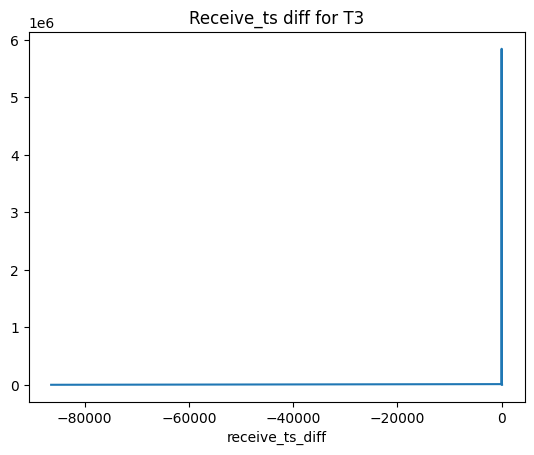

In [11]:
data = trade_data['receive_ts_diff'].round(3).value_counts().sort_index()
data.plot(title=f"Receive_ts diff for T3")
plt.show()

In [13]:
# Выведем максимальные средние и минимальные значения по серверам

print("T3")
print(f"Max: {trade_data['receive_ts_diff'].max()}")
print(f"Mean: {trade_data['receive_ts_diff'].mean().round(7)}")
print(f"Min: {trade_data['receive_ts_diff'].min().round(7):.5f}")
print()

T3
Max: 80.3271
Mean: 0.0024487
Min: -86399.96704



## Выводы

- Средние значения `receive_ts_diff` для всех данных на сервере `T1` выше, чем на сервере `T3`.
- Максимальные значения `receive_ts_diff` для всех данных на сервере `T1` выше, чем на сервере `T3`.
- Минимальные значения `receive_ts_diff` для всех данных на сервере `T1` ниже, чем на сервере `T3`.


In [168]:
# Посчитаем количество значений, аггрегируем их используя count_values и выведем в таблицу и сохраним в csv, проанализируем их. Максимальное минимальное и среднее значение
for security in SECURITIES:
    for server in SERVERS:
        # data = .value_counts().sort_index()
        print(f"Security: {security}, Server: {server}")
        print(trade_data[security][server]['receive_ts_diff'].describe())
        print()




Security: BTCUSDT, Server: T1
count    4.816600e+05
mean     8.967867e+04
std      1.341813e+05
min      1.400000e+01
25%      1.026800e+04
50%      3.992200e+04
75%      1.131402e+05
max      5.201854e+06
Name: receive_ts_diff, dtype: float64

Security: BTCUSDT, Server: T3
count    5.030060e+05
mean     8.587260e+04
std      1.325095e+05
min      4.600000e+01
25%      7.670000e+03
50%      3.599950e+04
75%      1.075358e+05
max      5.204183e+06
Name: receive_ts_diff, dtype: float64

Security: 1000PEPEUSDT, Server: T1
count    5.089590e+05
mean     8.487896e+04
std      1.500758e+05
min      1.400000e+01
25%      4.785000e+03
50%      2.412900e+04
75%      9.751300e+04
max      5.357998e+06
Name: receive_ts_diff, dtype: float64

Security: 1000PEPEUSDT, Server: T3
count    5.451990e+05
mean     7.923696e+04
std      1.465160e+05
min      4.200000e+01
25%      2.991000e+03
50%      1.938300e+04
75%      8.861800e+04
max      5.356191e+06
Name: receive_ts_diff, dtype: float64

